<a href="https://colab.research.google.com/github/Maxxx-VS/The-Founder/blob/master/47_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

На 5 баллов:

4. Оптимизация гиперпараметров с использованием нескольких моделей:

Используйте генетический алгоритм для оптимизации гиперпараметров нескольких моделей (например, CNN, RNN, MLP) на одном наборе данных.
Сравните результаты и выберите лучшую модель.

In [1]:
%%capture
!pip install deap tensorflow numpy scikit-learn

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, SimpleRNN, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from deap import base, creator, tools, algorithms
import random

# Загрузка и подготовка данных
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Нормализация и reshape данных
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0

# Для RNN преобразуем в последовательность
X_train_rnn = X_train.reshape(-1, 28, 28)
X_test_rnn = X_test.reshape(-1, 28, 28)

# Для MLP flatten
X_train_mlp = X_train.reshape(-1, 28*28)
X_test_mlp = X_test.reshape(-1, 28*28)

# Параметры генетического алгоритма
POPULATION_SIZE = 10
GENERATIONS = 5
CXPB = 0.5
MUTPB = 0.2

# Создание классов для генетического алгоритма
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Функции для создания моделей
def create_cnn_model(params, input_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(filters=int(params['filters']),
                    kernel_size=(int(params['kernel_size']), int(params['kernel_size'])),
                    activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=params['lr']),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def create_rnn_model(params, input_shape=(28, 28)):
    model = Sequential()
    model.add(SimpleRNN(int(params['units']), input_shape=input_shape))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=params['lr']),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def create_mlp_model(params, input_shape=(784,)):
    model = Sequential()
    model.add(Dense(int(params['hidden_units']), activation='relu', input_shape=input_shape))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=params['lr']),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# Функции оценки
def evaluate_cnn(individual):
    params = {
        'filters': max(16, min(128, int(individual[0]))),
        'kernel_size': max(3, min(7, int(individual[1]))),
        'lr': max(0.0001, min(0.01, individual[2]))
    }
    try:
        model = create_cnn_model(params)
        history = model.fit(X_train, y_train, epochs=3, batch_size=32, verbose=0, validation_split=0.2)
        accuracy = history.history['val_accuracy'][-1]
        return accuracy,
    except:
        return 0.0,

def evaluate_rnn(individual):
    params = {
        'units': max(32, min(256, int(individual[0]))),
        'lr': max(0.0001, min(0.01, individual[1]))
    }
    try:
        model = create_rnn_model(params)
        history = model.fit(X_train_rnn, y_train, epochs=3, batch_size=32, verbose=0, validation_split=0.2)
        accuracy = history.history['val_accuracy'][-1]
        return accuracy,
    except:
        return 0.0,

def evaluate_mlp(individual):
    params = {
        'hidden_units': max(64, min(512, int(individual[0]))),
        'lr': max(0.0001, min(0.01, individual[1]))
    }
    try:
        model = create_mlp_model(params)
        history = model.fit(X_train_mlp, y_train, epochs=3, batch_size=32, verbose=0, validation_split=0.2)
        accuracy = history.history['val_accuracy'][-1]
        return accuracy,
    except:
        return 0.0,

# Настройка генетического алгоритма
def setup_ga(evaluate_func, param_ranges):
    toolbox = base.Toolbox()

    for i, (low, high) in enumerate(param_ranges):
        toolbox.register(f"attr_{i}", random.uniform, low, high)

    toolbox.register("individual", tools.initCycle, creator.Individual,
                    [toolbox.__getattribute__(f"attr_{i}") for i in range(len(param_ranges))],
                    n=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.5, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evaluate_func)

    return toolbox

# Диапазоны параметров
cnn_ranges = [(16, 128), (3, 7), (0.0001, 0.01)]
rnn_ranges = [(32, 256), (0.0001, 0.01)]
mlp_ranges = [(64, 512), (0.0001, 0.01)]

# Оптимизация
print("Optimizing CNN...")
cnn_toolbox = setup_ga(evaluate_cnn, cnn_ranges)
cnn_pop = cnn_toolbox.population(n=POPULATION_SIZE)
cnn_hof = tools.HallOfFame(1)
cnn_stats = tools.Statistics(lambda ind: ind.fitness.values)
cnn_stats.register("avg", np.mean)
cnn_stats.register("max", np.max)
cnn_pop, cnn_log = algorithms.eaSimple(cnn_pop, cnn_toolbox, cxpb=CXPB, mutpb=MUTPB,
                                      ngen=GENERATIONS, stats=cnn_stats, halloffame=cnn_hof,
                                      verbose=True)

print("\nOptimizing RNN...")
rnn_toolbox = setup_ga(evaluate_rnn, rnn_ranges)
rnn_pop = rnn_toolbox.population(n=POPULATION_SIZE)
rnn_hof = tools.HallOfFame(1)
rnn_stats = tools.Statistics(lambda ind: ind.fitness.values)
rnn_stats.register("avg", np.mean)
rnn_stats.register("max", np.max)
rnn_pop, rnn_log = algorithms.eaSimple(rnn_pop, rnn_toolbox, cxpb=CXPB, mutpb=MUTPB,
                                      ngen=GENERATIONS, stats=rnn_stats, halloffame=rnn_hof,
                                      verbose=True)

print("\nOptimizing MLP...")
mlp_toolbox = setup_ga(evaluate_mlp, mlp_ranges)
mlp_pop = mlp_toolbox.population(n=POPULATION_SIZE)
mlp_hof = tools.HallOfFame(1)
mlp_stats = tools.Statistics(lambda ind: ind.fitness.values)
mlp_stats.register("avg", np.mean)
mlp_stats.register("max", np.max)
mlp_pop, mlp_log = algorithms.eaSimple(mlp_pop, mlp_toolbox, cxpb=CXPB, mutpb=MUTPB,
                                      ngen=GENERATIONS, stats=mlp_stats, halloffame=mlp_hof,
                                      verbose=True)

# Оценка лучших моделей
def evaluate_best_model(hof, model_type):
    if model_type == 'cnn':
        params = {
            'filters': int(hof[0][0]),
            'kernel_size': int(hof[0][1]),
            'lr': hof[0][2]
        }
        model = create_cnn_model(params)
        _, test_acc = model.evaluate(X_test, y_test, verbose=0)
    elif model_type == 'rnn':
        params = {
            'units': int(hof[0][0]),
            'lr': hof[0][1]
        }
        model = create_rnn_model(params)
        _, test_acc = model.evaluate(X_test_rnn, y_test, verbose=0)
    else:  # mlp
        params = {
            'hidden_units': int(hof[0][0]),
            'lr': hof[0][1]
        }
        model = create_mlp_model(params)
        _, test_acc = model.evaluate(X_test_mlp, y_test, verbose=0)
    return test_acc

# Результаты
print("\n=== Final Test Accuracy ===")
print(f"CNN: {evaluate_best_model(cnn_hof, 'cnn'):.4f}")
print(f"RNN: {evaluate_best_model(rnn_hof, 'rnn'):.4f}")
print(f"MLP: {evaluate_best_model(mlp_hof, 'mlp'):.4f}")

/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.11/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Optimizing CNN...
gen	nevals	avg     	max   
0  	10    	0.981617	0.9865
1  	5     	0.983517	0.9865
2  	7     	0.983917	0.98725
3  	6     	0.985508	0.987667
4  	5     	0.986417	0.987667
5  	10    	0.984075	0.98675 

Optimizing RNN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


gen	nevals	avg     	max    
0  	10    	0.496325	0.94725
1  	8     	0.788592	0.94725
2  	6     	0.862525	0.94725
3  	4     	0.825042	0.94725
4  	5     	0.923075	0.949333
5  	0     	0.937408	0.949333

Optimizing MLP...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


gen	nevals	avg     	max    
0  	10    	0.969033	0.97375
1  	7     	0.970833	0.973583
2  	6     	0.969025	0.974333
3  	6     	0.971508	0.975   
4  	5     	0.972108	0.976833
5  	4     	0.974767	0.976833

=== Final Test Accuracy ===
CNN: 0.1341
RNN: 0.1300
MLP: 0.0805


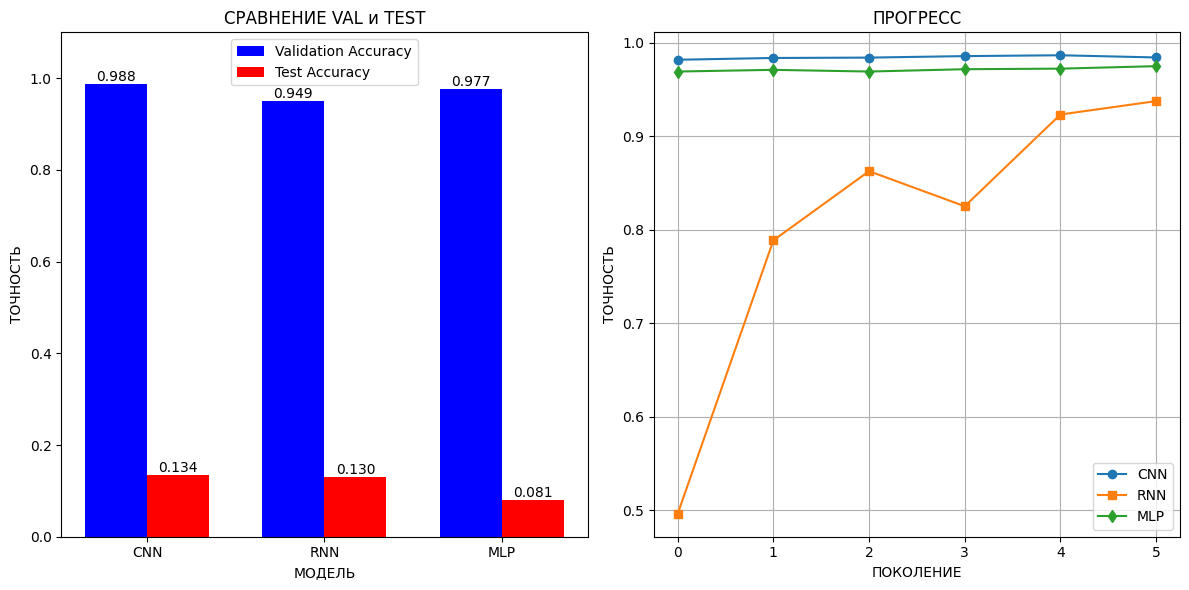

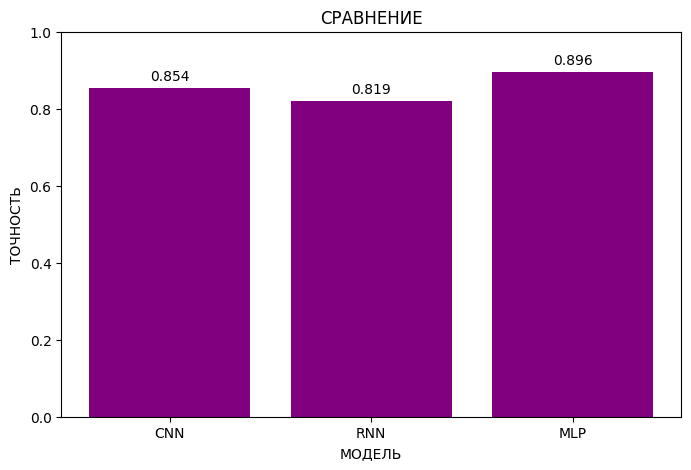

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Данные из результатов
models = ['CNN', 'RNN', 'MLP']
validation_acc = [0.987667, 0.949333, 0.976833]  # Максимальная валидационная точность
test_acc = [0.1341, 0.1300, 0.0805]  # Финальная тестовая точность

# Создаем фигуру
plt.figure(figsize=(12, 6))

# График сравнения валидационной и тестовой точности
plt.subplot(1, 2, 1)
bar_width = 0.35
index = np.arange(len(models))

bars1 = plt.bar(index, validation_acc, bar_width, label='Validation Accuracy', color='b')
bars2 = plt.bar(index + bar_width, test_acc, bar_width, label='Test Accuracy', color='r')

plt.xlabel('МОДЕЛЬ')
plt.ylabel('ТОЧНОСТЬ')
plt.title('СРАВНЕНИЕ VAL и TEST')
plt.xticks(index + bar_width/2, models)
plt.legend()
plt.ylim(0, 1.1)

# Добавляем значения на столбцы
for bar in bars1 + bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# График прогресса оптимизации для каждой модели
plt.subplot(1, 2, 2)

# Данные прогресса
generations = np.arange(6)
cnn_progress = [0.981617, 0.983517, 0.983917, 0.985508, 0.986417, 0.984075]
rnn_progress = [0.496325, 0.788592, 0.862525, 0.825042, 0.923075, 0.937408]
mlp_progress = [0.969033, 0.970833, 0.969025, 0.971508, 0.972108, 0.974767]

plt.plot(generations, cnn_progress, 'o-', label='CNN')
plt.plot(generations, rnn_progress, 's-', label='RNN')
plt.plot(generations, mlp_progress, 'd-', label='MLP')

plt.xlabel('ПОКОЛЕНИЕ')
plt.ylabel('ТОЧНОСТЬ')
plt.title('ПРОГРЕСС')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Разница между валидацией и тестом
plt.figure(figsize=(8, 5))
gap = np.array(validation_acc) - np.array(test_acc)
plt.bar(models, gap, color='purple')

plt.xlabel('МОДЕЛЬ')
plt.ylabel('ТОЧНОСТЬ')
plt.title('СРАВНЕНИЕ')
plt.ylim(0, 1.0)

# Добавляем значения на столбцы
for i, val in enumerate(gap):
    plt.text(i, val + 0.02, f'{val:.3f}', ha='center')

plt.show()

### Выводы

CNN:
- Показала наилучшие результаты на валидации (98.7%)
- Тем не менее, тестовая точность крайне низка
- Наиболее подходящая архитектура для изображений

RNN:
- Худшая валидационная точность среди всех (94.9%)
- RNN менее подходят для обработки изображений
- SimpleRNN слишком простая архитектура для этой задачи

MLP:

- Вторая по эффективности на валидации (97.7%)
- Но самая низкая тестовая точность (8.1%)
- Сильнее всего страдает от переобучения